In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim


# make data list ---------------------------------------------------------
REBUILD_DATA = False
DataList = "PetImages/Traing_Data_List.npy"

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    trainingData = []
    catCount = 0
    dogCount = 0
    
    def make_training_data(self):
        for label in self.LABELS:    # label -> path
            print(label)
            for f in tqdm(os.listdir(label)):    # f -> img name, ex: 1.jpg 2.jpg ...
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # one hot, np.eye(2)[0] -> [1, 0], np.eye(5)[2] -> [0, 0, 1, 0, 0]
                    self.trainingData.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catCount += 1
                    elif label == self.DOGS:
                        self.dogCount += 1
                except Exception as e:
                    pass
                    #print("IMG ERROR: ", e)
        
        np.random.shuffle(self.trainingData)
        np.save(DataList, self.trainingData)
        print("Cats: ", self.catCount)
        print("Dogs: ", self.dogCount)
            

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()
                
training_data = np.load(DataList, allow_pickle=True)
print(f"Data load down! {len(training_data)} imgs")


# net structure -----------------------------------------------------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*2*2, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


# data split ---------------------------------------------------------------
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print("DATA SPLIT DONE")


# cuda is on ---------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("RUNNING GPU")
else:
    device = torch.device("cpu")
    print("RUNNING CPU")
    

# net set ------------------------------------------------------------------
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

Data load down! 24946 imgs
DATA SPLIT DONE
RUNNING GPU


In [2]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss
    

In [4]:
def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(f"ACC: {val_acc}, LOSS: {val_loss}")

ACC: 0.5625,LOSS: 0.2496219277381897


In [6]:
import time

MODEL_NAME = f"DogsCatsModel-{time.time()}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 10
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=32)
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}\n")

train()                

  0%|▎                                                                                 | 1/225 [00:00<00:26,  8.42it/s]

DogsCatsModel-1600438293.709308


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:13<00:00, 16.80it/s]


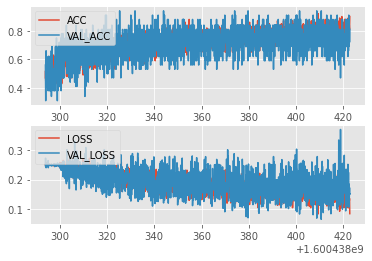

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas 

style.use("ggplot")
model_name = MODEL_NAME

def creat_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accs = []
    losses = []
    
    val_accs = []
    val_losses = []
    
    for c in contents:
        if model_name in c:
            name, time, acc, loss, val_acc, val_loss = c.split(",")
            times.append(float(time))
            accs.append(float(acc))
            losses.append(float(loss))
            
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    ax1.plot(times, accs, label="ACC")
    ax1.plot(times, val_accs, label="VAL_ACC")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="LOSS")
    ax2.plot(times, val_losses, label="VAL_LOSS")
    ax2.legend(loc=2)
    
    plt.show()
    
creat_acc_loss_graph(model_name)

# ACC and VAL_ACC keep together raise that mean you can keep going to training
# when they diverge, that mean you have problem
# usually loss will diverge first before ACC